# Analysis of Mental Health in Technology 
#### Kaylynn Crawford 

Visualization (analysis to come) here: https://silentttone.github.io/MentalHealth/

I'm using a dataset about mental health in technology to try to answer the question: what company policies are most effective in encouraging employees to get help for mental health disorders, if necessary? To do this I created a decision tree with "Treatment" as a response variable. 

Currently, I think the results are a bit muddled by variables that are too predictive, such as "Do you currently have a mental disorder." One of my next steps will be picking variables specific to company policy and seeing how useful the resulting tree is. 

### To Do: 
* Filter variables used (lots of unfairly useful ones are swaying the tree)
* Interpret results

### Further steps? 
 * Experiment with max_depth of tree
 * Try this in R and compare results (maybe. probably not.)

In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz

from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

%matplotlib inline

### Data Setup 

Reads in data, drops unwanted columns, converts all 'object' types to 'category', and drops rows without a current mental health disorder

In [7]:
# Read in file
data = pd.read_csv('../data/mentalHealth.csv')

# Remove columns with an unlimited number of options 
data = data.drop(['Gender', 'CountryLive', 'CountryWork', 'Position', 'StateLive', 'StateWork'], 1)

# Remove overly helpful data

#this could show your likelihood to get treatment regardless of company policy 
data = data.drop(['InterfereNotTreated', 'InterfereTreated'], 1) 

# Possibly pointless data
data = data.drop(['NumEmp'], 1)

# And muddling data
data = data.drop(['FamHistory', 'PastMental', 'FamMental'], 1)

# Convert all objects to category 
for n in list(data.columns.values): 
    if (data[n].dtype == object):
        data[n] = data[n].astype('category')   
        
# This removes all cases where CurMental == No
data = data[data.CurMental == "No"]

# For readability
data.ix[data.Treatment == 0, 'Treatment'] = "No"
data.ix[data.Treatment == 1, 'Treatment'] = "Yes"

### Deal with NaN Values

Drop the 11 columns with more than 400 no response values in order to get more complete datapoints with the remaining factors

In [9]:
# Drop columns with over 400 NaN values 
for n in list(data.columns.values):
    if(data[n].isnull().sum() > 400):
        print(n, data[n].isnull().sum())
        data = data.drop([n], axis=1)
    
# Remove any leftover rows with NaN values 
data = data.dropna(axis=0,how='any')

# Currently, this leaves us with 356 variables 
len(data)

356

### Prepare variables for model

Factorize categorical variables. 

In [10]:
# Reference: https://gist.github.com/ramhiser/982ce339d5f8c9a769a0

for n in list(data.columns.values): 
    if (str(data[n].dtype) == 'category'):
        one_hot = pd.get_dummies(data[n], prefix=n)
        data = data.drop(n, axis = 1)
        data = data.join(one_hot)

### Create training and test set

In [11]:
X = data.drop(['Treatment', 'CurMental_Maybe', 'CurMental_Yes', 'CurMental_No', 'Age'], axis=1)
y = data.Treatment

### Create decision tree

Using all data because I don't need predictive ability, and have a small sample size.

In [12]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X, y)
print (clf.score(X, y))
print (clf.classes_)

0.918539325843
['No' 'Yes']


### Visualize tree

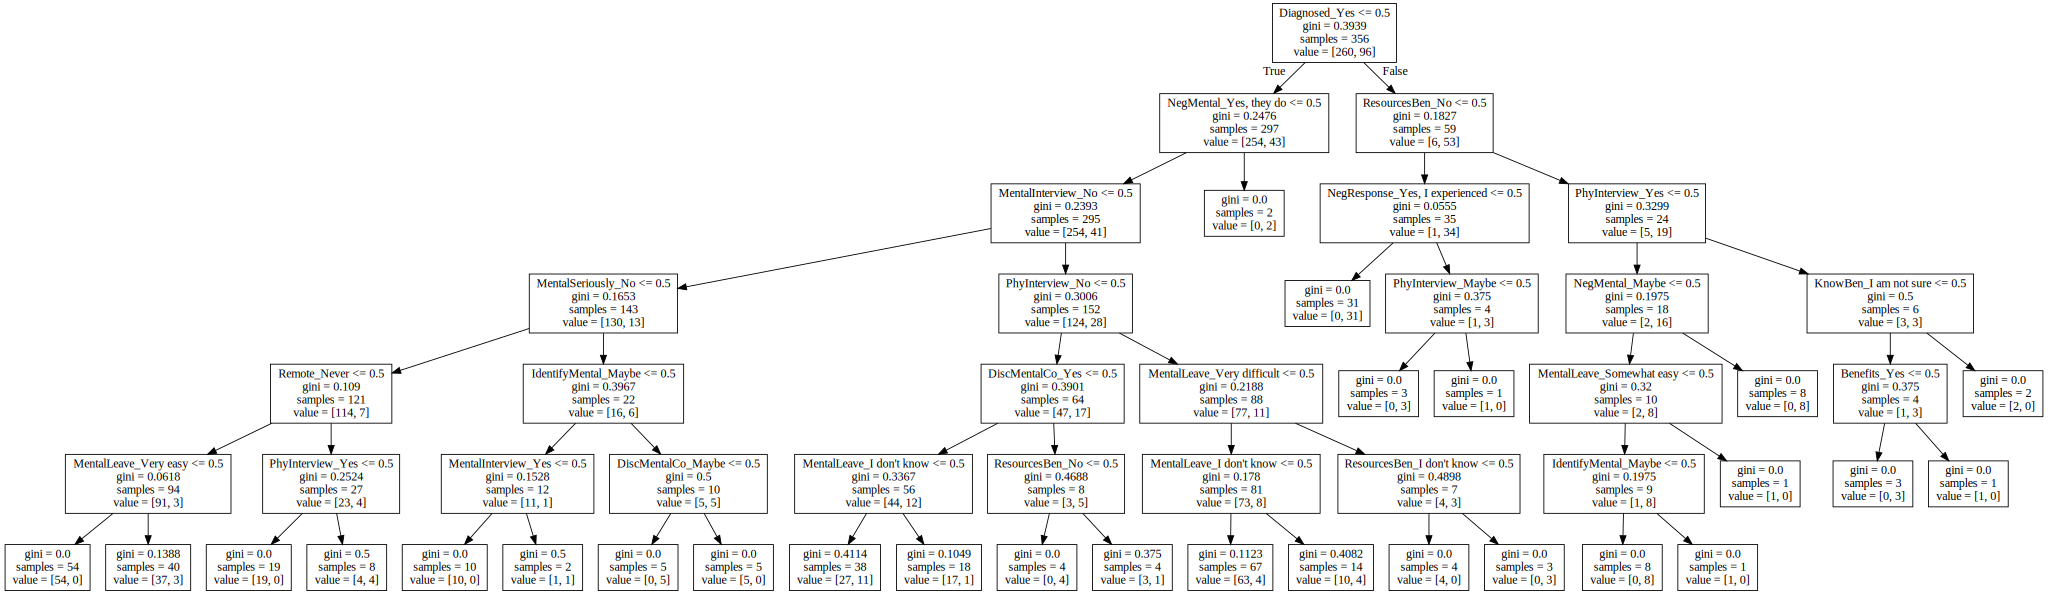

In [13]:
export_graphviz(clf, out_file="treatmentFactors.dot", feature_names=X.columns)
with open("treatmentFactors.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### Divide into Training and Test

Just out of curiosity

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.93258426966292129